<a href="https://colab.research.google.com/github/nupama-maxx/StockPricePrediction/blob/master/StocksPredictionPrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import normaltest
from statsmodels.tsa.stattools import acf,pacf
#from pmdarima.arima import auto_arima
import scipy.interpolate as sci
import scipy.optimize as sco
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import scipy.optimize as sco

In [10]:
df1 = pd.read_csv("AAPL.csv")
df2 = pd.read_csv("GOOG.csv")
df3 = pd.read_csv("AMZN.csv")

In [11]:
#setting date as index of dataframe

for df in (df1, df2, df3):
  df.set_index("Date", inplace=True)
  df.index = pd.to_datetime(df.index)

In [12]:
#merge the 3 dataframes

df=pd.DataFrame({"AAPL":[],"GOOG":[],"AMZN":[]})
symbols=['AAPL','GOOG','AMZN']
df.AAPL=df1.Close
df.GOOG=df2.Close
df.AMZN=df3.Close

In [13]:
df.head()

,AAPL,GOOG,AMZN
Date,,,
2021-08-02,145.520004,135.989502,166.574005
2021-08-03,147.360001,136.279999,168.311996
2021-08-04,146.949997,136.028503,167.735992
2021-08-05,147.059998,136.940002,168.799500
2021-08-06,146.139999,137.035995,167.246994


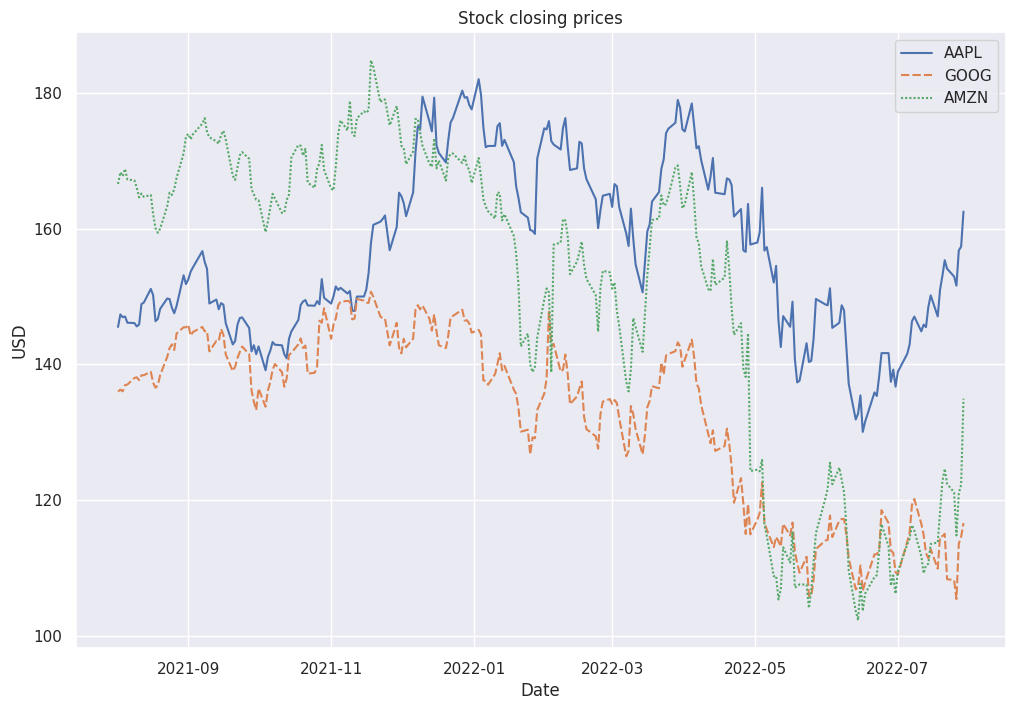

In [15]:
#initial plotting

plt.figure(figsize=(12,8))
sns.set_theme(style="darkgrid")
sns.lineplot(data=df)
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Stock closing prices')
plt.show()

<Figure size 640x480 with 0 Axes>

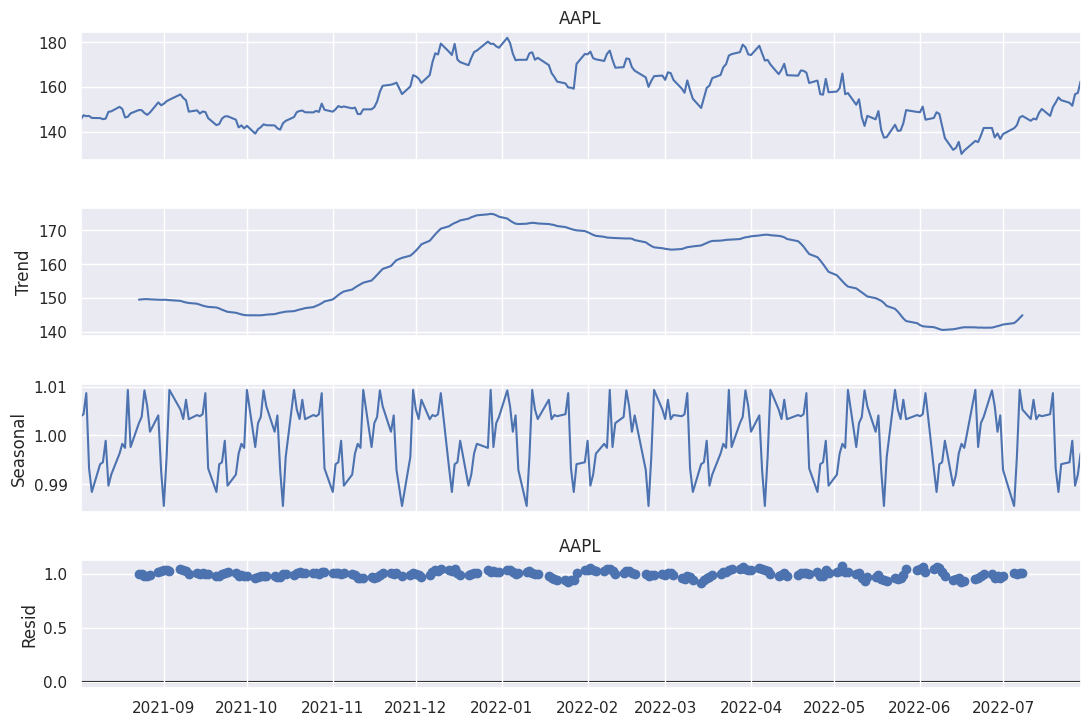

<Figure size 640x480 with 0 Axes>

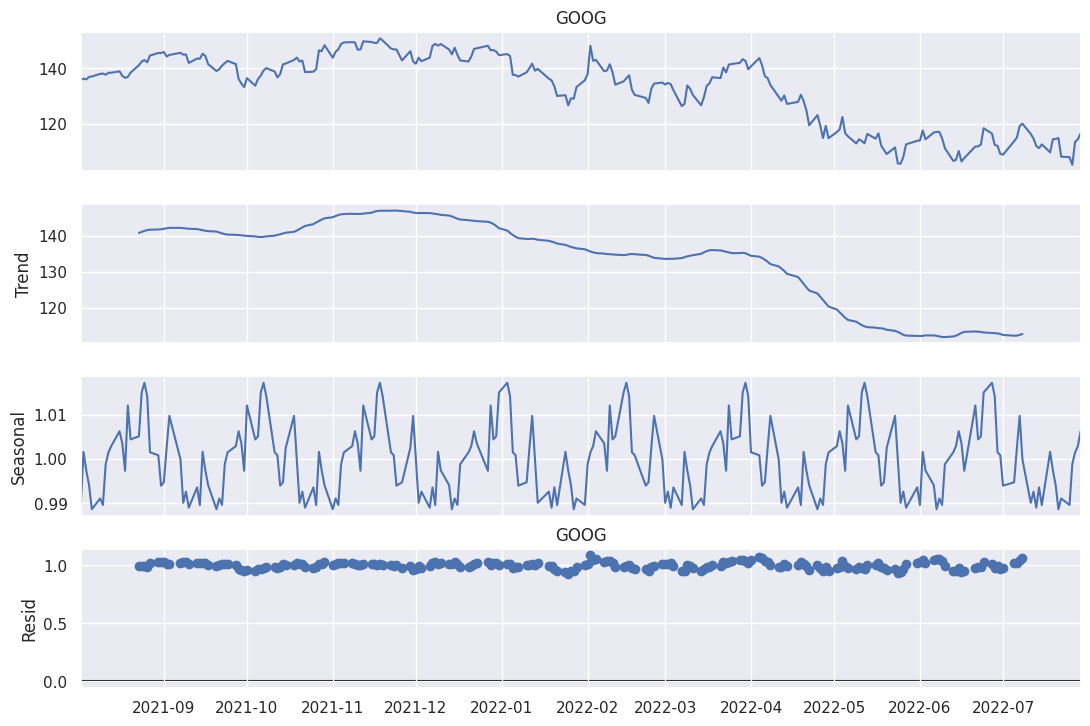

<Figure size 640x480 with 0 Axes>

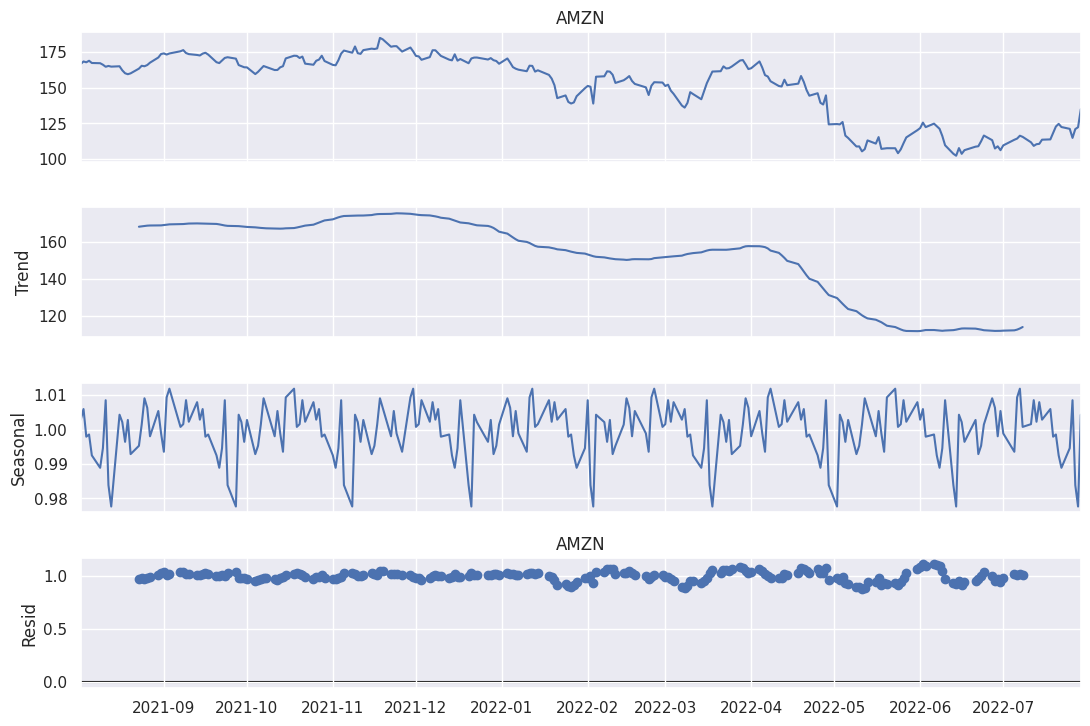

In [17]:
#seasonal decomposition
for i in symbols[0:]:
    result = seasonal_decompose(df[i], model='multiplicative', period=30)
    fig = plt.figure()
    fig = result.plot()
    plt.title(i)
    fig.set_size_inches(12, 8)
plt.show()

Observe the trend and seasonality in the data

Now, check the close price data for normality and stationarity


*   ADF Test
*   Normality Test


In [18]:
#ADF Test - tests whether a time series is stationary or not

for i in symbols:
  print([i])
  result = adfuller(df[i], autolag='AIC')
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))
  if result[0] < result[4]["5%"]:
      print ("Reject Null Hypothesis. So, Time Series is Stationary")
  else:
      print ("Failed to reject Null Hypothesis. So, Time Series is Not-Stationary")
  print("\n")

['AAPL']
ADF Statistic: -1.969605
p-value: 0.300057
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Failed to reject Null Hypothesis. So, Time Series is Not-Stationary


['GOOG']
ADF Statistic: -1.379294
p-value: 0.592162
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Failed to reject Null Hypothesis. So, Time Series is Not-Stationary


['AMZN']
ADF Statistic: -1.271892
p-value: 0.641931
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Failed to reject Null Hypothesis. So, Time Series is Not-Stationary




In [19]:
#Normality test

for i in symbols:
    print([i])
    stat, p = normaltest(df[i])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    alpha = 0.05
    if p > alpha:
        print('Data is normally distributed (fail to reject H0)')
    else:
        print('Data is not normally distributed(reject H0)')
    print('\n')



['AAPL']
Statistics=57.659, p=0.000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Data is not normally distributed(reject H0)


['GOOG']
Statistics=53.160, p=0.000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Data is not normally distributed(reject H0)


['AMZN']
Statistics=44.600, p=0.000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Data is not normally distributed(reject H0)




In [20]:
#log distribution -  makes highly skewed distribution less skewed

df_log = np.log(df / df.shift(1))

print(df_log.head())

                AAPL      GOOG      AMZN
Date                                    
2021-08-02       NaN       NaN       NaN
2021-08-03  0.012565  0.002134  0.010380
2021-08-04 -0.002786 -0.001847 -0.003428
2021-08-05  0.000748  0.006678  0.006320
2021-08-06 -0.006276  0.000701 -0.009240


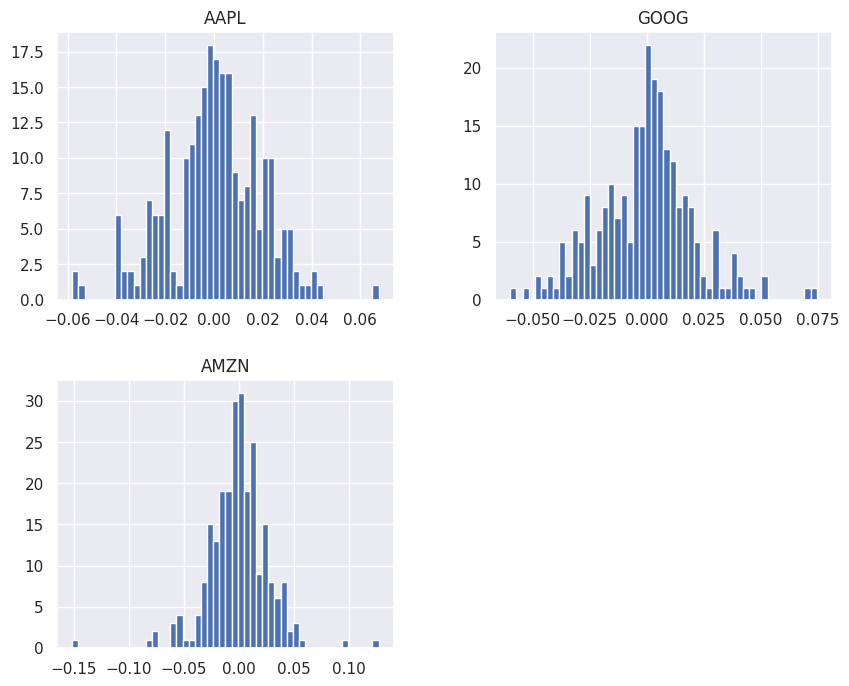

In [21]:
df_log.hist(bins=50, figsize=(10, 8))
plt.show()

In [22]:
df_log2 = df_log.dropna()
print(df_log2.head())

                AAPL      GOOG      AMZN
Date                                    
2021-08-03  0.012565  0.002134  0.010380
2021-08-04 -0.002786 -0.001847 -0.003428
2021-08-05  0.000748  0.006678  0.006320
2021-08-06 -0.006276  0.000701 -0.009240
2021-08-09 -0.000342  0.007025 -0.000918


Use the log transformed data to do ADF and Normality Test


In [23]:
#ADF Test
for i in symbols:
  print([i])
  result = adfuller(df_log2[i], autolag='AIC')
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))
  if result[0] < result[4]["5%"]:
      print ("Reject Null Hypothesis. So, Time Series is Stationary")
  else:
      print ("Failed to reject Null Hypothesis. So, Time Series is Non-Stationary")
  print("\n")

['AAPL']
ADF Statistic: -15.440370
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Reject Null Hypothesis. So, Time Series is Stationary


['GOOG']
ADF Statistic: -10.073409
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Reject Null Hypothesis. So, Time Series is Stationary


['AMZN']
ADF Statistic: -15.392716
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Reject Null Hypothesis. So, Time Series is Stationary




In [24]:
#Normality Test
for i in symbols:
    print([i])
    stat, p = normaltest(df_log2[i])
    print('Test Statistics=%.3f, p=%.3f' % (stat, p))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    alpha = 0.05
    if p > alpha:
        print('Data is normally distributed (fail to reject H0)')
    else:
        print('Data is not normally distributed(reject H0)')
    print('\n')

['AAPL']
Test Statistics=4.248, p=0.120
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Data is normally distributed (fail to reject H0)


['GOOG']
Test Statistics=6.899, p=0.032
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Data is not normally distributed(reject H0)


['AMZN']
Test Statistics=41.746, p=0.000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Data is not normally distributed(reject H0)




Data for all three stocks is now stationary, but only AAPL is normally distributed, the other two are not. To find the reason:


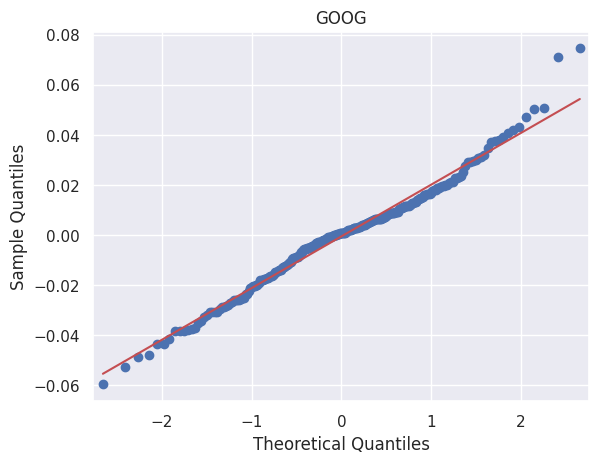

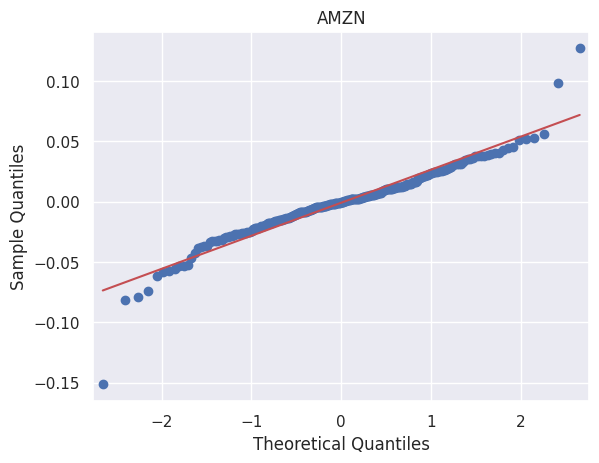

In [28]:
#QQ(Quantile-Quantile Plot)
fig = sm.qqplot(df_log2['GOOG'], line='s')
plt.title('GOOG')
plt.show()

fig = sm.qqplot(df_log2['AMZN'], line='s')
plt.title('AMZN')
plt.show()

Both stocks data lies mostly on the straight line with minor deviations, so both can be assumed normally distributed.

Now, constructing an ARIMA MODEL with auto-fitting parameters(p,d,q)

In [29]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.1 MB/s eta 0:00:00


In [30]:
from pmdarima import auto_arima

In [31]:
def arima_auto(arr):
    train_data=pd.DataFrame() # splitting into test and train data
    test_data=pd.DataFrame()
    plt.figure(figsize=(12,8))
    for i, sym in enumerate(symbols): # for all 3 stocks
        train_data[sym], test_data[sym] = df[sym][1:int(len(df[sym])*0.8)], df[sym][int(len(df)*0.8):]
        model = auto_arima(train_data[sym], trace=True, error_action='ignore', suppress_warnings=True)
        model.fit(train_data[sym]) # fitting the model
        forecast = model.predict(n_periods=len(test_data[sym]))
        forecast = pd.DataFrame(forecast,index = test_data.index) # plot the predictions for validation set
        plt.plot(train_data, label='Train {}'.format(sym))
        plt.plot(test_data, label='Test {}'.format(sym))
        plt.plot(forecast, label='Prediction {}'.format(sym))
    plt.title('Stocks Price Prediction\n')
    plt.xlabel('Date')
    plt.ylabel('Actual Stock Price')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
#    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=987.983, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=989.967, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=989.965, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=985.985, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.374 seconds
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=927.321, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=928.744, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=928.753, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=925.696, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=930.439, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.839 seconds
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1086.396, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1087.933, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1087.914, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1085.598, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1089.858, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.902 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


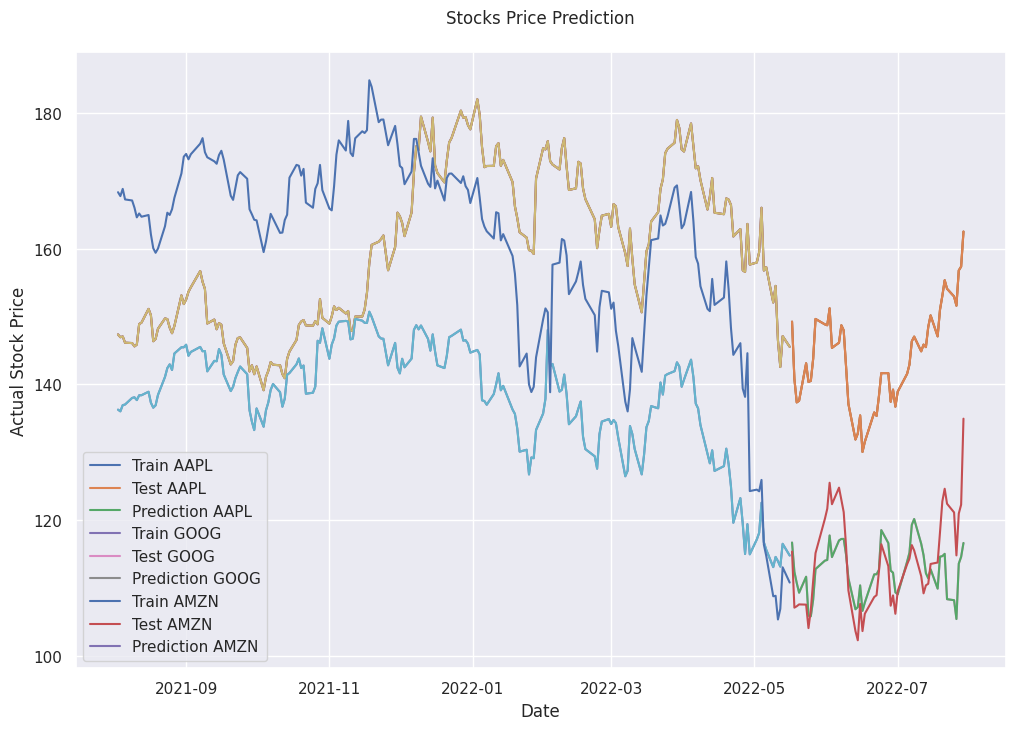

In [32]:
arima_auto(df)